### SVM (Support Vector Machine)

## Nonlinearly separable data  (SVM with Gaussian RBF Kernel)

The heart disease prediction dataset is an example of nonlinearly separable data because the data points cannot be separated by a linear decision boundary. In other words, it is not possible to draw a straight line that can completely separate the two classes. The SVM with a linear kernel may not be able to correctly classify the data points in this case.

To overcome this limitation, we can use a non-linear kernel, such as the Gaussian RBF kernel. The RBF kernel can handle non-linearly separable data by mapping the input features into a higher-dimensional space, where it is possible to find a hyperplane that can separate the classes. The Gaussian RBF kernel is a popular choice for SVMs because it is flexible and can capture complex patterns in the data.

Using the Gaussian RBF kernel, the SVM can construct a non-linear decision boundary that can accurately classify the heart disease prediction dataset. This allows for a more accurate prediction of the presence or absence of heart disease based on the input features.

In [7]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import Support Vector Classifier from library sklearn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix,  classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions

In [8]:
# Column 1: age in years
# Column 2: 1 = male, 0 = female
# Column 3: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
# Column 4: resting blood pressure in mmHg
# Column 5: in mg/dl
# Column 6: 1 means > 120 mg/dl, 0 means <= 120 mg/dl
# Column 7: resting electrocardiographic, 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
# Column 8: max heart rate achieved
# Column 9: 1 = yes, 2 = no
# Column 10: ST depression induced by exercise relative to rest
# Column 11: slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
# Column 12: number of major vessels (0-3) colored by flourosopy
# Column 13: 3 = normal, 6 = fixed defect, 7 = reversable defect
# Column 14: >=1 means heart disease, 0 = no heart disease

myNames = ["age", # column 1
        "sex", # col 2
        "chestPainType", # col 3
        "restingBP", # col 4
        "serumCholesterol", # col 5
        "fastingBloodSugar", # col 6
        "restingEcg", # col 7
        "maxHeartRate", # col 8
        "exerciseInducedAngina", # col 9
        "stDepression", # col 10
        "stSlope", # col 11
        "majorVessels", # col 12
        "thalassemia", # col 13
        "diagnosis"] # col 14
assert len(myNames) == 14
data=pd.read_csv("data/processed.cleveland.data", sep=',', names=myNames, na_values=["?", '?'])
data = data.dropna() # Drop rows with missing data
data.iloc[:, -1] = data.iloc[:, -1].clip(0, 1) # clip last column (output) between 0 and 1, both inclusive


# Convert all columns to float
for name in myNames:
    data[name] = pd.to_numeric(data[name],errors = 'coerce')

m = data.shape[0] # num examples
n = data.shape[1] - 1 # num features

print("Num features:", n)
print("Num examples:", m)
    
# a few examples from the dataset 
print()
print(data.head())

X = data.values[:, :-1]
y = data.values[:, -1:]

categoricalColumnsNames = ["sex", 
                      "chestPainType", 
                      "fastingBloodSugar", 
                      "restingEcg", 
                      "exerciseInducedAngina", 
                      "stSlope",
                      "majorVessels",
                      "thalassemia"]
continuousColumns = data.drop(categoricalColumnsNames, axis=1)
continuousColumnsNames = [name for name in myNames if name not in categoricalColumnsNames and name != "diagnosis"]
categoricalColumns = data.drop(continuousColumnsNames, axis=1)
if "diagnosis" in continuousColumns:
    continuousColumns = continuousColumns.drop("diagnosis", axis=1)
if "diagnosis" not in categoricalColumns:
    categoricalColumns = data["diagnosis"]

Num features: 13
Num examples: 297

    age  sex  chestPainType  restingBP  serumCholesterol  fastingBloodSugar  \
0  63.0  1.0            1.0      145.0             233.0                1.0   
1  67.0  1.0            4.0      160.0             286.0                0.0   
2  67.0  1.0            4.0      120.0             229.0                0.0   
3  37.0  1.0            3.0      130.0             250.0                0.0   
4  41.0  0.0            2.0      130.0             204.0                0.0   

   restingEcg  maxHeartRate  exerciseInducedAngina  stDepression  stSlope  \
0         2.0         150.0                    0.0           2.3      3.0   
1         2.0         108.0                    1.0           1.5      2.0   
2         2.0         129.0                    1.0           2.6      2.0   
3         0.0         187.0                    0.0           3.5      3.0   
4         2.0         172.0                    0.0           1.4      1.0   

   majorVessels  thalassem

In [3]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    X_norm = (X - mean)/ std
    
    return X_norm , mean , std

def costFunction(theta, X, y, C):
    # Takes in numpy array theta, X, y, and regularization parameter C
    # Returns the hinge loss for the SVC classifier
    
    # Create an SVC classifier with the RBF kernel
    classifier = SVC(kernel='rbf', C=C)
    
    # Fit the classifier to the training data
    classifier.fit(X, y)
    
    # Calculate the hinge loss
    hinge_loss = np.mean(np.maximum(0, 1 - classifier.decision_function(X) * y))
    
    return hinge_loss


In [9]:
# Create a train-test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(data.drop("diagnosis", axis=1), 
                                                data["diagnosis"], 
                                                test_size=0.25, 
                                                random_state=60)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Gaussian SVM training

Choose *rbf* (Radial Basis Function) kernel, which corresponds to Gaussian kernel. 

**gamma** parameter is the inverse of the standard deviation of the RBF kernel (gamma = $1/\sigma$). 
**gamma** is used as a similarity measure between two points. 

Small gamma value defines a Gaussian function with a large variance => two points are considered similar even if they are relatively far away from each other. 

Large gamma value defines a Gaussian function with a small variance => two points are considered similar if they are very close to each other.

In [13]:

# Non-linear SVM with RBF Kernel
print("Non-linear SVM with RBF Kernel")
print("--------------------------------")

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10]}

# Declare the classifier
classifier = SVC(kernel='rbf')

# Declare the GridSearchCV object
grid_classifier = GridSearchCV(classifier, param_grid, cv=5)

# Train the GridSearchCV object
grid_classifier.fit(X_train, np.ravel(y_train))

# Get the best parameters
best_params = grid_classifier.best_params_
print(f"Best parameters: {best_params}")

best_C = best_params['C']
best_gamma = best_params['gamma']

# Get the best score
best_score = grid_classifier.best_score_
print(f"Best score: {best_score:.2f}")

# Get the best estimator
best_classifier = grid_classifier.best_estimator_
print(f"Best estimator: {best_classifier}")

# Train the best estimator on the training data
best_classifier.fit(X_train, np.ravel(y_train))

# Predict the class labels for the test set
y_pred = best_classifier.predict(X_test)

# Get the classifier accuracy on training data
train_accuracy = best_classifier.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.2f}")

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing accuracy: {test_accuracy:.2f}")


# Get the classifier accuracy on validation data
val_accuracy = best_classifier.score(X_test, y_test)
print(f"Validation accuracy: {val_accuracy:.2f}")

# Train and evaluate the classifier using k-fold cross-validation on training data
scores = cross_val_score(best_classifier, X_train, np.ravel(y_train), cv=5)

# Print the average score and the standard deviation of the scores
print(f"Cross-validation accuracy on training data: {scores.mean():.2f} (+/- {scores.std():.2f})")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print(f"Actual No        {tn}               {fp}")
print(f"Actual Yes       {fn}               {tp}")

# Generate classification report
cr = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(cr)




Non-linear SVM with RBF Kernel
--------------------------------
Best parameters: {'C': 0.1, 'gamma': 0.1}
Best score: 0.84
Best estimator: SVC(C=0.1, gamma=0.1)
Training accuracy: 0.86
Testing accuracy: 0.83
Validation accuracy: 0.83
Cross-validation accuracy on training data: 0.84 (+/- 0.06)
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No        36               8
Actual Yes       5               26

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.76      0.84      0.80        31

    accuracy                           0.83        75
   macro avg       0.82      0.83      0.82        75
weighted avg       0.83      0.83      0.83        75



Linear SVM
----------
Best parameters: {'C': 0.1}
Best score: 0.83
Best estimator: SVC(C=0.1, kernel='linear')
Training accuracy: 0.85
Validation accuracy: 0.84
Testing accuracy: 0.84
Cross-validation accuracy on training data: 0.83 (+/- 0.04)
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No        37               7
Actual Yes       5               26

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        44
           1       0.79      0.84      0.81        31

    accuracy                           0.84        75
   macro avg       0.83      0.84      0.84        75
weighted avg       0.84      0.84      0.84        75



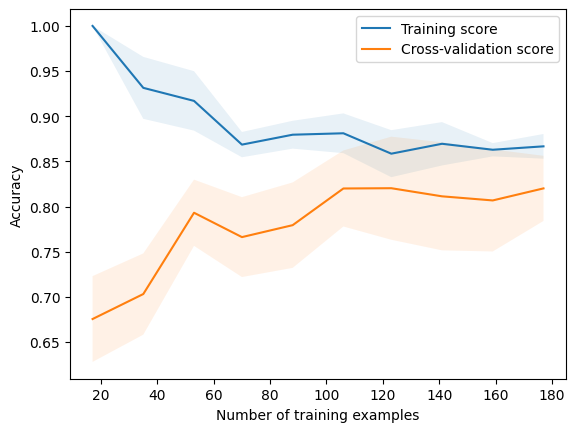

In [14]:
# Linear SVM
print("Linear SVM")
print("----------")

# Define the hyperparameter grid
param_grid_linear = {'C': [0.1, 1, 10]}

# Declare the linear SVM classifier
linear_classifier = SVC(kernel='linear')

# Declare the GridSearchCV object
grid_classifier_linear = GridSearchCV(linear_classifier, param_grid_linear, cv=5)

# Train the GridSearchCV object
grid_classifier_linear.fit(X_train, np.ravel(y_train))

# Get the best parameters
best_params_linear = grid_classifier_linear.best_params_
print(f"Best parameters: {best_params_linear}")

best_C_linear = best_params_linear['C']

# Get the best score
best_score_linear = grid_classifier_linear.best_score_
print(f"Best score: {best_score_linear:.2f}")

# Get the best estimator
best_classifier_linear = grid_classifier_linear.best_estimator_
print(f"Best estimator: {best_classifier_linear}")

# Train the best estimator on the training data
best_classifier_linear.fit(X_train, np.ravel(y_train))

# Predict the class labels for the test set
y_pred_linear = best_classifier_linear.predict(X_test)

# Get the classifier accuracy on training data
train_accuracy_linear = best_classifier_linear.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy_linear:.2f}")

# Get the classifier accuracy on validation data
val_accuracy_linear = best_classifier_linear.score(X_test, y_test)
print(f"Validation accuracy: {val_accuracy_linear:.2f}")

# Calculate the testing accuracy
test_accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Testing accuracy: {test_accuracy_linear:.2f}")

# Train and evaluate the classifier using k-fold cross-validation on training data
scores_linear = cross_val_score(best_classifier_linear, X_train, np.ravel(y_train), cv=5)

# Print the average score and the standard deviation of the scores
print(f"Cross-validation accuracy on training data: {scores_linear.mean():.2f} (+/- {scores_linear.std():.2f})")

# Compute the confusion matrix
cm_linear = confusion_matrix(y_test, y_pred_linear)
tn_linear, fp_linear, fn_linear, tp_linear = cm_linear.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print(f"Actual No        {tn_linear}               {fp_linear}")
print(f"Actual Yes       {fn_linear}               {tp_linear}")

# Generate classification report
cr_linear = classification_report(y_test, y_pred_linear)
print("\nClassification Report:")
print(cr_linear)

from sklearn.model_selection import learning_curve

# Create a linear SVM classifier object
linear_classifier = SVC(kernel='linear')

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=linear_classifier,
    X=X_train,
    y=np.ravel(y_train),
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:


# Fit the linear classifier on the entire dataset
linear_classifier.fit(X, np.ravel(y))

# Define the feature names (assuming X contains the feature values)
feature_names = ['Feature 1', 'Feature 2', 'Feature 3', ...]

# Plot the decision boundary
plot_decision_regions(X, np.ravel(y), clf=linear_classifier, feature_index=[0, 1], 
                      filler_feature_values={2: 0}, filler_feature_ranges={2: 1.0}, 
                      legend=2)

# Add axis labels and a title
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Decision Boundary Visualization")

# Show the plot
plt.show()
